In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt  

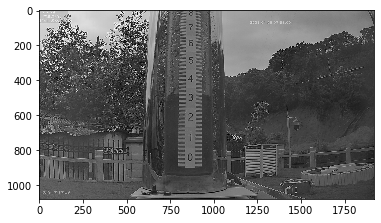

In [4]:
# 读入原始照片
# img = cv2.imread("sample2.jpg",0)
img = cv2.imread("sample8.jpg",0)

plt.imshow(img,cmap = 'gray')
plt.show()

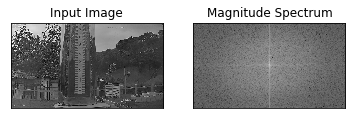

In [6]:
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

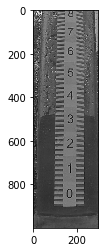

In [9]:
# 1 水表图形分割
aim = img[0:1000, 700:1000]

plt.imshow(aim,cmap = 'gray')
plt.show()

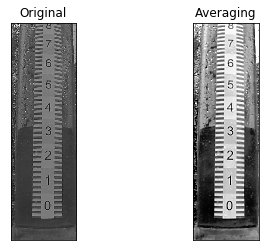

In [61]:
# 2. 预处理
# 2.1 直方图均衡化提高度对比度

# 查看原始直方图
# plt.hist(aim.ravel(),256,[0,256]);  
# plt.show() 

# 先平滑后均衡
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(aim,-1,kernel)

# dst = cv2.GaussianBlur(aim,(5,5),0)

equ = cv2.equalizeHist(dst)  

plt.subplot(121),plt.imshow(aim,cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(equ,cmap = 'gray'),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

# 查看平滑后直方图
# plt.hist(equ.ravel(),256,[0,256]);  
# plt.show() 

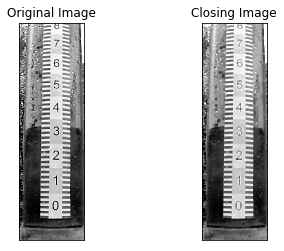

In [62]:
# 2.2 闭运算：先膨胀后腐蚀, 填充前景物体中的小洞
closing = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel)

plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
plt.subplot(122),plt.imshow(closing, cmap = 'gray')  
plt.title('Closing Image'), plt.xticks([]), plt.yticks([])  
plt.show()  

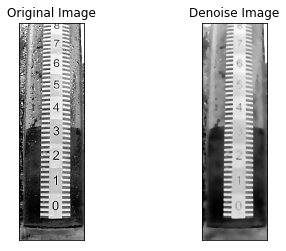

In [71]:
# 2.3 图像去噪
dst_de = cv2.fastNlMeansDenoising(closing, None, 50, 7, 21)

plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
plt.subplot(122),plt.imshow(dst_de, cmap = 'gray')  
plt.title('Denoise Image'), plt.xticks([]), plt.yticks([])  
plt.show()  

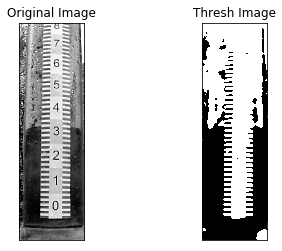

In [72]:
# 2.4 二值化
ret,thresh = cv2.threshold(dst_de,127,255,0)

plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
plt.subplot(122),plt.imshow(thresh, cmap = 'gray')  
plt.title('Thresh Image'), plt.xticks([]), plt.yticks([])  
plt.show() 

In [238]:
# 2.3 Canny 边缘检测
# edges = cv2.Canny(thresh,50,150)  

# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

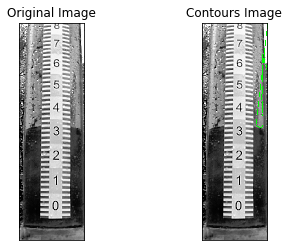

In [258]:
# 2.5 轮廓提取
ret,thresh = cv2.threshold(dst_de,127,255,0)

contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
result = cv2.drawContours(color, [contour[16]], -1, (0,255,0), 2) #轮廓用绿色绘制

plt.subplot(122),plt.imshow(result)  
plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
plt.show()  

1000
300


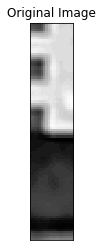

In [182]:
print(len(equ))
print(len(equ[0]))

x = 138
y = 901
plt.imshow(equ[y-50:y+50, x-10:x+10], cmap = 'gray')  
plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

plt.show()  

In [201]:
# 3 提取刻度位置

# 3.1 找出量表轮廓位置
maxA = 0
maxS = contour[0].size

for i in range(0, len(contour)):
    if (contour[i].size > maxS):
        maxA = i
        maxS = contour[i].size 
# print(maxA, maxS)  

# 3.2 分割出量表区域 [st : en]
st = 0
while (contour[maxA][st][0, 1] < len(equ) / 3 * 2):
    st += 1;
    
en = st + 1
while (contour[maxA][en][0, 1] > len(equ) / 3 * 2):
    en += 1; 
    
# print(st, en)  


# 3.3 找出最低端零刻度
Index_0 = 0
Height_0 = 0
for i in range(st, en):
    if (contour[maxA][i][0, 1] > Height_0):
        Index_0 = i
        Height_0 = contour[maxA][i][0, 1]

# print(contour[maxA][Index_0]) # 零刻度位置

# 3.4 记录零刻度边界
arr_zero = []

left_0 = contour[maxA][Index_0][0, 0]
right_0 = left_0

for i in range(st, en):
    if (abs(contour[maxA][i][0, 1] - Height_0) < 5):
        arr_zero.append(contour[maxA][i])
        if (contour[maxA][i][0, 0] < left_0):
            left_0 = contour[maxA][i][0, 0]
        if (contour[maxA][i][0, 0] > right_0):
            right_0 = contour[maxA][i][0, 0]    
        
# print(left_0, right_0) # 零刻度坐标

515 939
[[138 901]]
134 196


In [254]:
## 3.5 记录刻度位置数组

arr_peak = []
left_bound = right_0

for i in range(st, en):
    i_x = contour[maxA][i][0, 0]
    
    if (i_x > left_bound):
        left_bound = i_x

    peak = True
    
    j = 1
    if (i_x <= contour[maxA][i - j][0, 0]):
        while (i_x == contour[maxA][i - j][0, 0]):
            j += 1
        if (i_x < contour[maxA][i - j][0, 0]):
            peak = False
    
    if (not peak):
        continue
    
    j = 1
    if (i_x <= contour[maxA][i + j][0, 0]):
        while (i_x == contour[maxA][i + j][0, 0]):
            j += 1
        if (i_x < contour[maxA][i + j][0, 0]):
            peak = False
    
    if peak and abs(left_0 - contour[maxA][i][0, 0]) < 10:
        arr_peak.append(contour[maxA][i][0])
        # arr_peak.append(i)
        
# print(arr_peak) # 刻度坐标 

## 3.6 计算单位刻度长度

div = 0
num = 0
pre = arr_peak[0][1]
for i in range(1, len(arr_peak)):
    if abs(arr_peak[i][1] - pre) > 5:
        div += (arr_peak[i][1] - pre)
        num += 1
    pre = arr_peak[i][1]

lengthPer = div / num # 单位刻度

# print(lengthPer)

18.7


In [268]:
# 3.6 获得轮廓转折点
# print(left_bound) # 刻度右边界

rub = en

for i in range(en, len(contour[maxA])):
    if(contour[maxA][i][0, 0] - left_bound) > 10:
        print(contour[maxA][i])
        rub = i
        break
        
# 3.7 寻找水位线
waterLine = contour[maxA][rub][0, 1]
# print(waterLine)

# for i in range(rub, len(contour[maxA]) - 1):
#     if (contour[maxA][i][0, 1] < waterLine):
#         # print(contour[maxA][i])
#         waterLine = contour[maxA][i][0, 1]   
# print(waterLine)

# 3.8 计算当前水位
print("当前水位为：", (Height_0 - waterLine) / (lengthPer * 10))

233
[[245 473]]
473
当前水位为： 2.2887700534759357


In [255]:
left_bound

233

In [252]:
contour[maxA][en][0, 1]

665

[[200 665]]
[[202 663]]
[[214 663]]
[[215 664]]
[[219 664]]
[[220 663]]
[[230 663]]
[[232 661]]
[[232 660]]
[[233 659]]
[[233 654]]
[[232 653]]
[[232 652]]
[[230 650]]
[[227 650]]
[[226 649]]
[[219 649]]
[[218 648]]
[[208 648]]
[[207 647]]
[[203 647]]
[[200 644]]
[[200 642]]
[[202 640]]
[[207 640]]
[[208 639]]
[[209 639]]
[[210 640]]
[[230 640]]
[[232 638]]
[[232 637]]
[[233 636]]
[[233 633]]
[[232 632]]
[[232 630]]
[[231 629]]
[[230 629]]
[[229 628]]
[[225 628]]
[[224 627]]
[[216 627]]
[[215 626]]
[[207 626]]
[[206 625]]
[[202 625]]
[[200 623]]
[[200 619]]
[[201 618]]
[[206 618]]
[[207 617]]
[[225 617]]
[[226 618]]
[[229 618]]
[[230 617]]
[[231 617]]
[[232 616]]
[[232 613]]
[[233 612]]
[[232 611]]
[[232 608]]
[[231 607]]
[[231 606]]
[[230 606]]
[[229 605]]
[[225 605]]
[[224 604]]
[[217 604]]
[[216 603]]
[[209 603]]
[[208 602]]
[[204 602]]
[[203 601]]
[[202 601]]
[[200 599]]
[[200 597]]
[[202 595]]
[[205 595]]
[[206 594]]
[[216 594]]
[[217 595]]
[[230 595]]
[[232 593]]
[[232 591]]
[[23

In [234]:
# !!!!!!!!!!!!!!!!!!!!

# 腐蚀 
# erosion = cv2.erode(aim,kernel,iterations = 1)

# plt.subplot(121),plt.imshow(aim, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(erosion, cmap = 'gray')  
# plt.title('Erosion Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

In [17]:
# 先均衡后平滑
# equ = cv2.equalizeHist(aim)

# kernel = np.ones((5,5),np.float32)/25
# dst = cv2.filter2D(equ,-1,kernel)

# plt.subplot(121),plt.imshow(equ,cmap = 'gray'),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(dst,cmap = 'gray'),plt.title('Averaging')
# plt.xticks([]), plt.yticks([])
# plt.show()

In [7]:
# 低通滤波
# kernel = np.ones((5,5),np.float32)/25
# dst = cv2.filter2D(equ,-1,kernel)

# plt.subplot(121),plt.imshow(equ,cmap = 'gray'),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(dst,cmap = 'gray'),plt.title('Averaging')
# plt.xticks([]), plt.yticks([])
# plt.show()

In [8]:
# 图像平滑
# blur = cv2.blur(equ,(5,5))

# plt.subplot(121),plt.imshow(equ,cmap = 'gray'),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(blur,cmap = 'gray'),plt.title('Blurred')
# plt.xticks([]), plt.yticks([])
# plt.show()

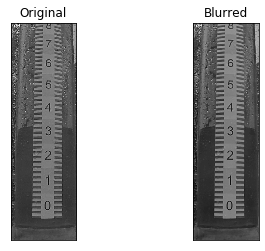

In [10]:
# 高斯滤波
blur = cv2.GaussianBlur(aim,(5,5),0)

plt.subplot(121),plt.imshow(aim,cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur,cmap = 'gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
# 双边滤波
# blur = cv2.bilateralFilter(equ,9,75,75)

# plt.subplot(121),plt.imshow(equ,cmap = 'gray'),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(blur,cmap = 'gray'),plt.title('Blurred')
# plt.xticks([]), plt.yticks([])
# plt.show()

In [11]:
# 拉普拉斯算子
# laplacian=cv2.Laplacian(aim,cv2.CV_64F)
# # 参数1,0 为只在x 方向求一阶导数，最大可以求2 阶导数。
# sobelx=cv2.Sobel(aim,cv2.CV_64F,1,0,ksize=5)
# # 参数0,1 为只在y 方向求一阶导数，最大可以求2 阶导数。
# sobely=cv2.Sobel(aim,cv2.CV_64F,0,1,ksize=5)

# plt.subplot(2,2,1),plt.imshow(aim,cmap = 'gray')
# plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
# plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
# plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
# plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
# plt.show()

In [66]:
# 膨胀
# dilation = cv2.dilate(aim,kernel,iterations = 1)
# plt.subplot(121),plt.imshow(aim, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(dilation, cmap = 'gray')  
# plt.title('Dilation Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

In [233]:
# !!!!!!!!!!!!!!!!!!!!
# 刻度被腐蚀，影响标量测量

# 开运算：先腐蚀后膨胀, 去除噪声
# opening = cv2.morphologyEx(equ, cv2.MORPH_OPEN, kernel)

# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(opening, cmap = 'gray')  
# plt.title('Opening Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

In [232]:
# Canny 边缘检测 - sample 4
# edges = cv2.Canny(closing,50,200)  

# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

In [231]:
# 形态学梯度
# blur = cv2.GaussianBlur(equ,(5,5),0)
# gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)

# plt.subplot(121),plt.imshow(aim, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(gradient, cmap = 'gray')  
# plt.title('Gradient Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

In [230]:
# canny
# edges = cv2.Canny(gradient,128,256,True)

# plt.subplot(121),plt.imshow(gradient, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

In [228]:
# 霍夫变换 - sample 3
# lines = cv2.HoughLines(edges,1,np.pi/180,200)
# imgC = img[0:1000, 700:1000]
# img2 = img[0:1000, 700:1000]
# print(lines)

# for rho,theta in lines[0]:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))
    
#     cv2.line(img2,(x1,y1),(x2,y2),(0,255,0),2)
    
# plt.subplot(121),plt.imshow(imgC)  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(img2)  
# plt.title('Hough Image'), plt.xticks([]), plt.yticks([])  
# plt.show() 

In [229]:
# 3 去除斑块

# 3.1 sobel算子
# x_gray = cv2.Sobel(closing,cv2.CV_32F,1,0)
# y_gray = cv2.Sobel(closing,cv2.CV_32F,0,1)

# x_gray = cv2.convertScaleAbs(x_gray)
# y_gray = cv2.convertScaleAbs(y_gray)

# dst = cv2.add(x_gray,y_gray,dtype=cv2.CV_16S)
# dst = cv2.convertScaleAbs(dst)

# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(dst, cmap = 'gray')  
# plt.title('Sobel Image'), plt.xticks([]), plt.yticks([])  
# plt.show()

# 3.2 连通域分析
# ret,thresh = cv2.threshold(closing,127,255,0)
# num_labels,labels,stats,centers = cv2.connectedComponentsWithStats(thresh, connectivity=8,ltype=cv2.CV_32S)

# for t in range(1, num_labels, 1):
#         x, y, w, h, area = stats[t]
#         if area>100:
#             index = np.where(labels==t)
#             labels[index[0], index[1]] = 0
            
# dst2 = cv2.filter2D(aim,-1,kernel)
# equ2 = cv2.equalizeHist(dst2)  

# 方法 1：
# dst_TELEA = cv2.inpaint(equ2,labels,3,cv2.INPAINT_TELEA)
# 方法2：
# dst_NS = cv2.inpaint(img,mask,3,cv2.INPAINT_NS)

# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(labels, cmap = 'gray')  
# plt.title('TELEA Image'), plt.xticks([]), plt.yticks([])  
# plt.show() 